In [1]:
import numpy as np
import torch

import pandas as pd
import json
import os
import pickle
import yaml
from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt

from cellmincer.models import DenoisingModel, init_model, get_best_window_padding
from cellmincer.util import \
    OptopatchBaseWorkspace, \
    OptopatchDenoisingWorkspace, \
    const, \
    crop_center


def psnr(
    clean: np.ndarray,
    noisy: np.ndarray,
    peak: int):
    
    assert clean.shape == noisy.shape, f'{clean.shape} != {noisy.shape}'
    mse = np.mean(np.square(clean - noisy), axis=tuple(range(1, clean.ndim)))
    psnr = 10 * np.log10(peak * peak / mse)
    
    return psnr

def trim_segments(movie_txy, len_segment, trim_left, trim_right):
    return np.concatenate([movie_txy[i + trim_left:i + len_segment - trim_right] for i in range(0, len(movie_txy), len_segment)])

## Load configs

In [2]:
yaml_file = '/home/jupyter/bw-code/CellMincer/configs/denoise/spatial-unet-2d-temporal-denoiser-optosynth-cosine-anneal.yaml'

try:
    with open(yaml_file, 'r') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)
except IOError:
    raise RuntimeError(f'Error loading the input YAML file {args.input_yaml_file}!')

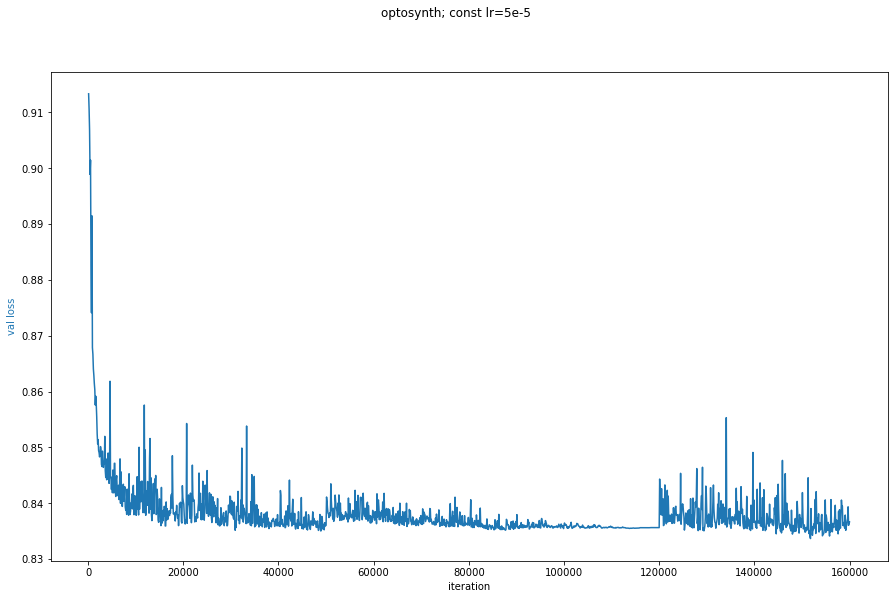

In [12]:
fig, ax1 = plt.subplots(figsize=(15, 9))
fig.suptitle('optosynth; const lr=5e-5')
ax1.set_xlabel('iteration')

color = line_colors[0]
# plt.plot(train_loss['iter'], train_loss['total_loss'])
ax1.plot(val_loss['iter'], val_loss['val_loss'], color=color)
ax1.set_ylabel('val loss', color=color)
# ax2.tick_params(axis='y', colors=color)
fig.show()

## Load dataset

In [3]:
dataset_dir = os.path.join(params['root_data_dir'], params['datasets'][0])

base_diff_path = os.path.join(dataset_dir, 'trend_subtracted.npy')
ws_base_diff = OptopatchBaseWorkspace.from_npy(base_diff_path)

base_bg_path = os.path.join(dataset_dir, 'trend.npy')
ws_base_bg = OptopatchBaseWorkspace.from_npy(base_bg_path)

opto_noise_params_path = os.path.join(dataset_dir, 'noise_params.json')
with open(opto_noise_params_path, 'r') as f:
    noise_params = json.load(f)

opto_feature_path = os.path.join(dataset_dir, 'features.pkl')
with open(opto_feature_path, 'rb') as f:
    feature_container = pickle.Unpickler(f).load()

_, x_padding = get_best_window_padding(
        model_config=params['model'],
        output_min_size_lo=ws_base_diff.width,
        output_min_size_hi=ws_base_diff.width)

_, y_padding = get_best_window_padding(
        model_config=params['model'],
        output_min_size_lo=ws_base_diff.height,
        output_min_size_hi=ws_base_diff.height)

ws_denoising = OptopatchDenoisingWorkspace(
    ws_base_diff=ws_base_diff,
    ws_base_bg=ws_base_bg,
    noise_params=noise_params,
    features=feature_container,
    x_padding=x_padding,
    y_padding=y_padding,
    device=params['device'],
    dtype=const.DEFAULT_DTYPE
)

In [4]:
clean_movie_txy = np.load(
    '/home/jupyter/bw-data/cellmincer/data/optosynth_first_wave__1__20__50/clean_movie_tyx.npy'
).transpose((0, 2, 1))

In [5]:
params['model']['n_global_features'] = ws_denoising.n_global_features
model_dir = '/home/jupyter/bw-data/cellmincer/models/optosynth-cosine-anneal'

denoising_model = init_model(
    params['model'],
    device=params['device'],
    dtype=const.DEFAULT_DTYPE)

denoising_model.eval()

SpatialUnet2dTemporalDenoiser(
  (spatial_unet): GUNet(
    (drop): Dropout2d(p=0.0, inplace=False)
    (down_path): ModuleList(
      (0): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(75, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (3): ReLU()
          (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
        )
      )
      (1): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(106, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
        )
      )
      (2): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(138, 128, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride

In [6]:
psnr_iter = []
psnr_mean = []
psnr_std = []

for i_state in trange(4, 321, 4):
    denoising_model.load_state_dict(torch.load(
        os.path.join(model_dir, f'states/model_state__{i_state:06d}.pt')))
    
    denoised_movie_txy = crop_center(
        denoising_model.denoise_movie(ws_denoising).numpy(),
        target_width=ws_denoising.width,
        target_height=ws_denoising.height)
    
    denoised_movie_txy *= ws_denoising.cached_features.norm_scale
    denoised_movie_txy += ws_denoising.ws_base_bg.movie_txy
    
    psnr_t = psnr(clean_movie_txy, denoised_movie_txy, 2 ** 16 - 1)
    
    psnr_iter.append(i_state * 500)
    psnr_mean.append(np.mean(psnr_t))
    psnr_std.append(np.std(psnr_t))

  0%|          | 0/80 [00:00<?, ?it/s]

In [51]:
# train_loss = pd.read_csv(os.path.join(model_dir, f'{0:06d}/train_loss.csv'))
val_loss = pd.read_csv(os.path.join(model_dir, f'{240:06d}/val_loss.csv'))

In [52]:
import colorsys
from PIL import ImageColor

def get_desaturated(color, desat):
    r, g, b = ImageColor.getrgb(color)
    h, l, s = colorsys.rgb_to_hls(r / 255, g / 255, b / 255)
    return colorsys.hls_to_rgb(h, 1 - desat * (1 - l), s) + (0.5,)

line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]

fill_colors = [get_desaturated(color, 0.5) for color in line_colors]

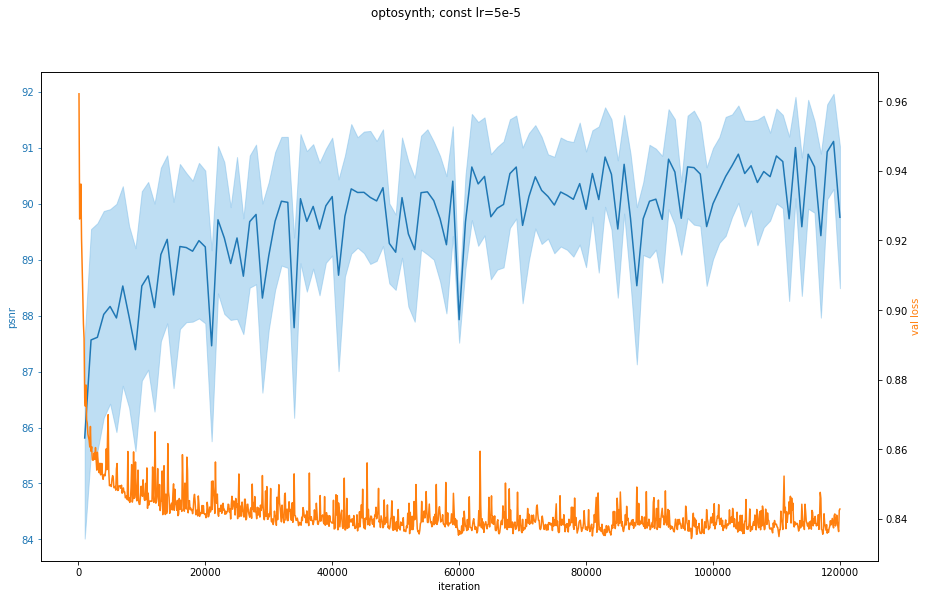

In [74]:
psnr_iter = np.array(psnr_iter)
psnr_mean = np.array(psnr_mean)
psnr_std = np.array(psnr_std)

fig, ax1 = plt.subplots(figsize=(15, 9))
fig.suptitle('optosynth; const lr=5e-5')
ax1.set_xlabel('iteration')

color = line_colors[0]
ax1.plot(psnr_iter, psnr_mean, color=color)
ax1.fill_between(psnr_iter, psnr_mean - psnr_std / 2, psnr_mean + psnr_std / 2, color=fill_colors[0])
ax1.set_ylabel('psnr', color=color)
ax1.tick_params(axis='y', colors=color)

color = line_colors[1]
ax2 = ax1.twinx()
# plt.plot(train_loss['iter'], train_loss['total_loss'])
ax2.plot(val_loss['iter'], val_loss['val_loss'], color=color)
ax2.set_ylabel('val loss', color=color)
# ax2.tick_params(axis='y', colors=color)
fig.show()

In [57]:
model_dir_1 = os.path.join(params['root_model_dir'], 'optosynth')

psnr_iter_1 = []
psnr_mean_1 = []
psnr_std_1 = []

for i_state in trange(6, 241, 6):
    denoising_model.load_state_dict(torch.load(
        os.path.join(model_dir_1, f'{i_state:06d}', 'model_state.pt')))
    
    denoised_movie_txy = crop_center(
        denoising_model.denoise_movie(ws_denoising).numpy(),
        target_width=ws_denoising.width,
        target_height=ws_denoising.height)
    
    denoised_movie_txy *= ws_denoising.cached_features.norm_scale
    denoised_movie_txy += ws_denoising.ws_base_bg.movie_txy
    
    psnr_t = psnr(clean_movie_txy, denoised_movie_txy, 2 ** 16 - 1)
    
    psnr_iter_1.append(i_state * 500)
    psnr_mean_1.append(np.mean(psnr_t))
    psnr_std_1.append(np.std(psnr_t))

  0%|          | 0/40 [00:00<?, ?it/s]

In [58]:
val_loss_1 = pd.read_csv(os.path.join(model_dir_1, f'{240:06d}/val_loss.csv'))

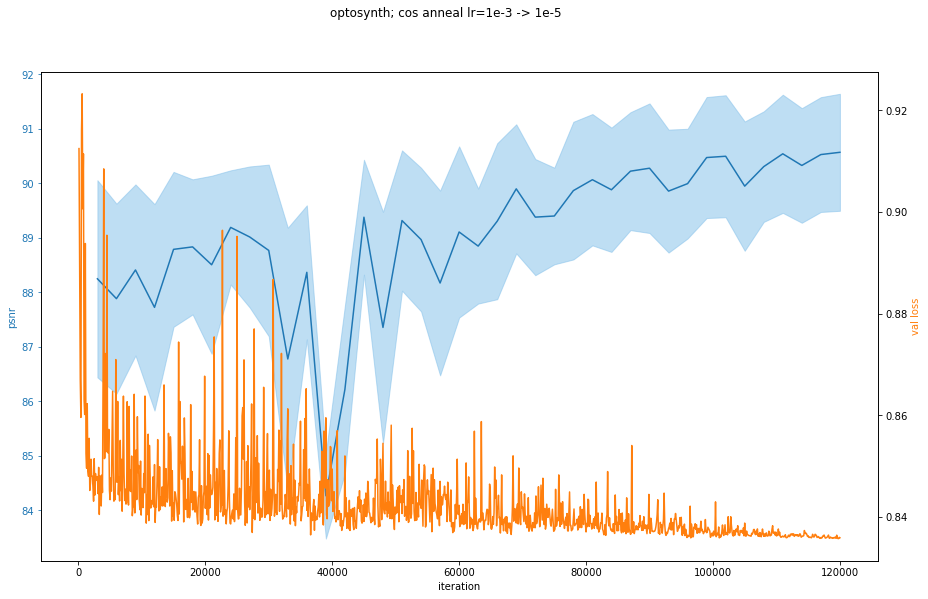

In [75]:
psnr_iter_1 = np.array(psnr_iter_1)
psnr_mean_1 = np.array(psnr_mean_1)
psnr_std_1 = np.array(psnr_std_1)

fig, ax1 = plt.subplots(figsize=(15, 9))
fig.suptitle('optosynth; cos anneal lr=1e-3 -> 1e-5')
ax1.set_xlabel('iteration')

color = line_colors[0]
ax1.plot(psnr_iter_1, psnr_mean_1, color=color)
ax1.fill_between(psnr_iter_1, psnr_mean_1 - psnr_std_1 / 2, psnr_mean_1 + psnr_std_1 / 2, color=fill_colors[0])
ax1.set_ylabel('psnr', color=color)
ax1.tick_params(axis='y', colors=color)

color = line_colors[1]
ax2 = ax1.twinx()
# plt.plot(train_loss['iter'], train_loss['total_loss'])
ax2.plot(val_loss_1['iter'], val_loss_1['val_loss'], color=color)
ax2.set_ylabel('val loss', color=color)
# ax2.tick_params(axis='y', colors=color)
fig.show()